# Exploring Keyboard Data

1. Load the data
    - Create a dataframe of all data folders
    - additional features are Name of user, filename, Keyboard Material, microphone
2. Clean up where it's unknown
    - Impute values from online, or set generic value.


End result: One dataframe of information

Cluster data

Visualize those clusters

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yaml
import librosa
import soundfile as sf

## Old Data before rework

In [7]:
# Define the path to the data folder
data_folder = '../data/'

# Initialize an empty list to store the data
key_data_list = []
sentence_data_list = []

# Loop through all user folders in the data folder
for user_folder in os.listdir(data_folder):
    if 'Keystroke' in user_folder:
        continue
    user_folder_path = os.path.join(data_folder, user_folder)
    if os.path.isdir(user_folder_path):  # Check if it's a directory
        key_folder_path = os.path.join(user_folder_path, 'data', 'key_data')
        sentence_folder_path = os.path.join(user_folder_path, 'data', 'sentence_data')

        # Key data, then sentence data
        # for internal_folder in [key_folder_path, sentence_folder_path]:
        for file_name in os.listdir(key_folder_path):
            # key_folder_path = os.path.join(data_folder, user_folder)
            # Check if the file is a YAML file
            if file_name.endswith('.yaml'):
                # Extract key_pressed value from the filename
                key_pressed = file_name.split('_')[2]
                
                # Construct the full path to the YAML file
                yaml_file_path = os.path.join(key_folder_path, file_name)
                
                # Read the YAML file and filter out the 'key_pressed' field and subsequent lines until 'keyboard_name'
                with open(yaml_file_path, 'r') as file:
                    lines = file.readlines()
                
                filtered_lines = []
                skip = False
                for line in lines:
                    if line.strip().startswith('key_pressed:'):
                        skip = True
                    if skip and line.strip().startswith('keyboard_name:'):
                        skip = False
                    if not skip:
                        filtered_lines.append(line)
                
                # Load the filtered lines into a dictionary
                yaml_data = yaml.safe_load(''.join(filtered_lines))
                
                # Add the user, audio file name, and key_pressed information
                yaml_data['user'] = user_folder
                yaml_data['audio_file'] = file_name.replace('.yaml', '.wav')  # Assuming audio files are in .wav format
                yaml_data['key_pressed'] = key_pressed
                
                # Append the data to the list
                key_data_list.append(yaml_data)

# Convert the list of dictionaries to a DataFrame
key_df = pd.DataFrame(key_data_list)
sentence_df = pd.DataFrame(sentence_data_list)

# Display the DataFrame
key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed
0,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383597,Basem,key_press_z_1720383597.wav,z
1,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383403,Basem,key_press_k_1720383403.wav,k
2,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720380835,Basem,key_press_4_1720380835.wav,4
3,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383189,Basem,key_press_f_1720383189.wav,f
4,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383147,Basem,key_press_d_1720383147.wav,d


----------
Grabbing new data

### Find the peak for each audio file, then seperate them out.

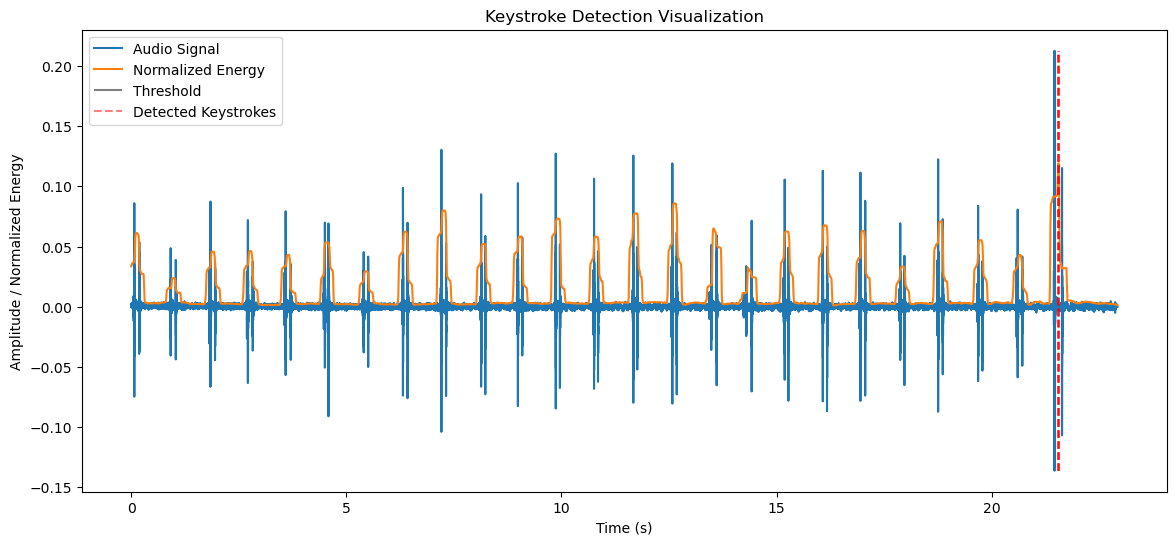

In [11]:
def calculate_energy(y, sr):
    # Perform STFT
    stft_result = np.abs(librosa.stft(y))
    
    # Calculate energy
    energy = np.sum(stft_result**2, axis=0)
    
    # Normalize energy
    energy = energy / np.max(energy)
    
    return energy

def sliding_window_average(energy, window_size):
    averaged_energy = np.convolve(energy, np.ones(window_size)/window_size, mode='same')
    return averaged_energy

def visualize_keystrokes(audio_path, threshold, window_size=10):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Calculate energy
    energy = calculate_energy(y, sr)
    
    # Apply sliding window average
    averaged_energy = sliding_window_average(energy, window_size)

    # Detect keystrokes
    keystroke_indices = np.where(averaged_energy > threshold)[0]
    
    # Convert indices to time
    times = librosa.frames_to_time(keystroke_indices, sr=sr)
    
    # Plot audio waveform
    plt.figure(figsize=(14, 6))
    plt.plot(np.arange(len(y)) / sr, y, label='Audio Signal')
    
    # Plot energy
    plt.plot(librosa.frames_to_time(np.arange(len(averaged_energy)), sr=sr), averaged_energy, label='Normalized Energy')
    
    # Plot energy threshold
    plt.hlines([threshold for _ in range(len(times))], xmin=threshold, xmax=threshold, color='k', alpha=0.5, linestyle='-', label='Threshold')
    # Mark detected keystrokes
    plt.vlines(times, ymin=min(y), ymax=max(y), color='r', alpha=0.5, linestyle='--', label='Detected Keystrokes')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude / Normalized Energy')
    plt.title('Keystroke Detection Visualization')
    plt.legend()
    plt.show()



def extract_keystrokes(audio_path, threshold, output_dir, window_size=50):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Calculate energy
    energy = calculate_energy(y, sr)
    
    # Apply sliding window average
    averaged_energy = sliding_window_average(energy, window_size)

    # Detect keystrokes
    keystroke_indices = np.where(averaged_energy > threshold)[0]
    
    

    # # Ignore indices that are within 0.2 seconds of a previously detected peak
    # time_threshold_frames = int(0.2 * sr / librosa.frames_to_samples(1))
    # filtered_keystroke_indices = []
    # for idx in keystroke_indices:
    #     if len(filtered_keystroke_indices) == 0 or (idx - filtered_keystroke_indices[-1]) > time_threshold_frames:
    #         filtered_keystroke_indices.append(idx)

    # Group keystroke indices
    keystroke_groups = []
    if len(keystroke_indices) > 0:
        current_group = [keystroke_indices[0]]
        for i in range(1, len(keystroke_indices)):
            if keystroke_indices[i] - keystroke_indices[i-1] > 1:  # assuming keystrokes are at least one frame apart
                keystroke_groups.append(current_group)
                current_group = [keystroke_indices[i]]
            else:
                current_group.append(keystroke_indices[i])
        keystroke_groups.append(current_group)
    
    # Save individual keystroke audio files
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i, group in enumerate(keystroke_groups):
        # Find the center of the group
        center_index = np.mean(group).astype(int)
        
        # Ensure both peaks are included
        start_frame = max(0, group[0] - 1)  # Start a bit earlier
        end_frame = min(len(energy), group[-1] + 1)  # End a bit later
        
        start_sample = librosa.frames_to_samples(start_frame)
        end_sample = librosa.frames_to_samples(end_frame + 1)
        
        keystroke_audio = y[start_sample:end_sample]
        output_path = os.path.join(output_dir, f'keystroke_{i}.wav')
        sf.write(output_path, keystroke_audio, sr)
        print(f'Saved keystroke {i} to {output_path}')

# Example usage
audio_path = 'E_25_presses_modified.wav'
threshold = 0.1  # Adjust this threshold to visualize its effect
visualize_keystrokes(audio_path, threshold, window_size=20)
# threshold = 0.15  # Adjust this threshold based on your data
# output_dir = 'new_files_test'

# Extract keystrokes with the chosen threshold
# extract_keystrokes(audio_path, threshold, output_dir)


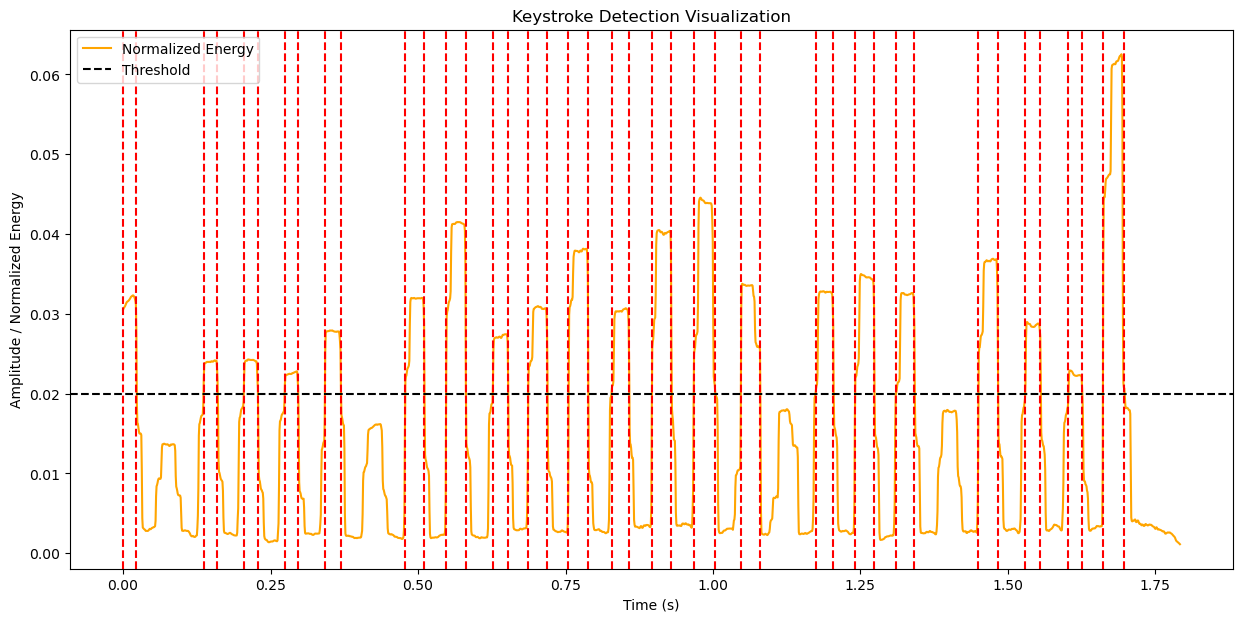

In [21]:
import numpy as np
import librosa
import soundfile as sf
import os

def calculate_energy(y, sr):
    # Perform STFT
    stft_result = np.abs(librosa.stft(y))
    
    # Calculate energy
    energy = np.sum(stft_result**2, axis=0)
    
    # Normalize energy
    energy = energy / np.max(energy)
    
    return energy

def sliding_window_average(energy, window_size):
    averaged_energy = np.convolve(energy, np.ones(window_size)/window_size, mode='same')
    return averaged_energy

def extract_keystrokes(audio_path, threshold, output_dir, window_size=50):
    y, sr = librosa.load(audio_path, sr=None)
    energy = calculate_energy(y, sr)
    averaged_energy = sliding_window_average(energy, window_size)
    
    keystroke_indices = np.where(averaged_energy > threshold)[0]
    
    keystroke_events = []
    if len(keystroke_indices) > 0:
        start_idx = keystroke_indices[0]
        for i in range(1, len(keystroke_indices)):
            if keystroke_indices[i] - keystroke_indices[i-1] > 1:
                end_idx = keystroke_indices[i-1]
                keystroke_events.append((start_idx, end_idx))
                start_idx = keystroke_indices[i]
        keystroke_events.append((start_idx, keystroke_indices[-1]))
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # for i, (start_frame, end_frame) in enumerate(keystroke_events):
    #     start_sample = librosa.frames_to_samples(start_frame)
    #     end_sample = librosa.frames_to_samples(end_frame + 1)
        
    #     keystroke_audio = y[start_sample:end_sample]
    #     output_path = os.path.join(output_dir, f'keystroke_{i}.wav')
    #     sf.write(output_path, keystroke_audio, sr)
    #     print(f'Saved keystroke {i} to {output_path}')
    
    # Plot for visualization
    time = np.linspace(0, len(y) / sr, len(y))
    frames_time = np.linspace(0, len(energy) * window_size / sr, len(energy))
    
    plt.figure(figsize=(15, 7))
    # plt.plot(time, y, label='Audio Signal')
    plt.plot(frames_time, averaged_energy, label='Normalized Energy', color='orange')
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    for start_frame, end_frame in keystroke_events:
        plt.axvline(x=start_frame * window_size / sr, color='red', linestyle='--')
        plt.axvline(x=end_frame * window_size / sr, color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude / Normalized Energy')
    plt.legend()
    plt.title('Keystroke Detection Visualization')
    plt.show()

# Example usage
# Example usage
audio_path = 'E_25_presses_modified.wav'
threshold = 0.02  # Adjust this threshold based on your data
output_dir = 'new_files_test'

# Extract keystrokes with the chosen threshold
extract_keystrokes(audio_path, threshold, output_dir, window_size=40)

New method: two thresholds.

Saved keystroke 0 to new_files_test/keystroke_0.wav
Saved keystroke 1 to new_files_test/keystroke_1.wav
Saved keystroke 2 to new_files_test/keystroke_2.wav
Saved keystroke 3 to new_files_test/keystroke_3.wav
Saved keystroke 4 to new_files_test/keystroke_4.wav
Saved keystroke 5 to new_files_test/keystroke_5.wav
Saved keystroke 6 to new_files_test/keystroke_6.wav
Saved keystroke 7 to new_files_test/keystroke_7.wav
Saved keystroke 8 to new_files_test/keystroke_8.wav
Saved keystroke 9 to new_files_test/keystroke_9.wav
Saved keystroke 10 to new_files_test/keystroke_10.wav
Saved keystroke 11 to new_files_test/keystroke_11.wav
Saved keystroke 12 to new_files_test/keystroke_12.wav
Saved keystroke 13 to new_files_test/keystroke_13.wav
Saved keystroke 14 to new_files_test/keystroke_14.wav


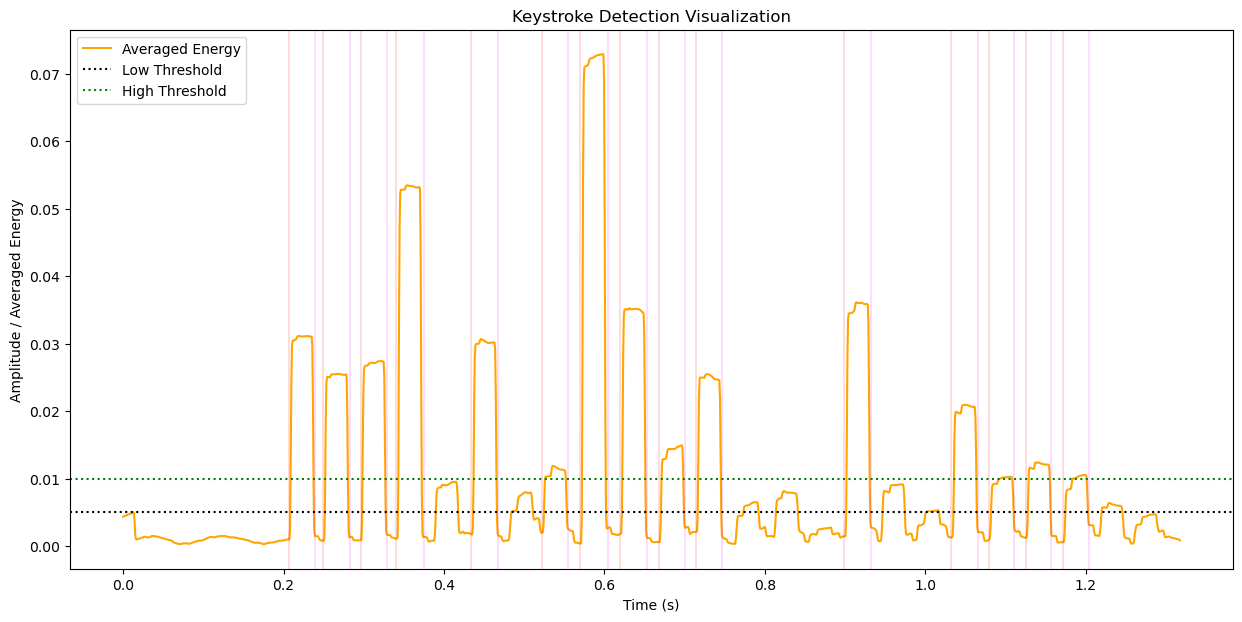

In [45]:
import numpy as np
import librosa
import soundfile as sf
import os

def calculate_energy(y, sr):
    stft_result = np.abs(librosa.stft(y))
    energy = np.sum(stft_result**2, axis=0)
    energy = energy / np.max(energy)
    return energy

def sliding_window_average(energy, window_size):
    averaged_energy = np.convolve(energy, np.ones(window_size)/window_size, mode='same')
    return averaged_energy

def extract_keystrokes(audio_path, low_threshold, high_threshold, output_dir,
                       window_size=50, target_duration=1.0, give_plot=False):
    y, sr = librosa.load(audio_path, sr=None)
    energy = calculate_energy(y, sr)
    averaged_energy = sliding_window_average(energy, window_size)
    
    keystroke_indices = np.where(averaged_energy > low_threshold)[0]
    
    keystroke_events = []
    if len(keystroke_indices) > 0:
        start_idx = keystroke_indices[0]
        for i in range(1, len(keystroke_indices)):
            if keystroke_indices[i] - keystroke_indices[i-1] > 1:
                end_idx = keystroke_indices[i-1]
                keystroke_events.append((start_idx, end_idx))
                start_idx = keystroke_indices[i]
        keystroke_events.append((start_idx, keystroke_indices[-1]))
    
    filtered_keystroke_events = []
    for start_frame, end_frame in keystroke_events:
        if np.max(averaged_energy[start_frame:end_frame]) > high_threshold:
            length = end_frame - start_frame
            extension = int(0.1 * length)
            start_frame = max(0, start_frame - extension)
            end_frame = min(len(averaged_energy), end_frame + extension)
            filtered_keystroke_events.append((start_frame, end_frame))
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i, (start_frame, end_frame) in enumerate(filtered_keystroke_events):
        start_sample = librosa.frames_to_samples(start_frame)
        end_sample = librosa.frames_to_samples(end_frame + 1)
        
        keystroke_audio = y[start_sample:end_sample]
        
        # Calculate required padding
        target_samples = int(target_duration * sr)
        current_samples = len(keystroke_audio)
        padding_needed = target_samples - current_samples
        if padding_needed > 0:
            pad_before = padding_needed // 2
            pad_after = padding_needed - pad_before
            keystroke_audio = np.pad(keystroke_audio, (pad_before, pad_after), 'constant')
        
        output_path = os.path.join(output_dir, f'keystroke_{i}.wav')
        sf.write(output_path, keystroke_audio, sr)
        print(f'Saved keystroke {i} to {output_path}')
    
    if give_plot:
        # Plot for visualization
        time = np.linspace(0, len(y) / sr, len(y))
        frames_time = np.linspace(0, len(energy) * window_size / sr, len(energy))
        
        plt.figure(figsize=(15, 7))
        # plt.plot(time, y, label='Audio Signal')
        plt.plot(frames_time, averaged_energy, label='Averaged Energy', color='orange')
        plt.axhline(y=low_threshold, color='black', linestyle=':', label='Low Threshold')
        plt.axhline(y=high_threshold, color='green', linestyle=':', label='High Threshold')
        for start_frame, end_frame in filtered_keystroke_events:
            plt.axvline(x=start_frame * window_size / sr, color='red', linestyle='-', linewidth=0.2)
            plt.axvline(x=end_frame * window_size / sr, color='magenta', linestyle='-', linewidth=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude / Averaged Energy')
        plt.legend()
        plt.title('Keystroke Detection Visualization')
        plt.show()

# Example usage
# Example usage 
audio_path = 'E_25_presses_modified.wav'
threshold = 0.02  # Adjust this threshold based on your data
output_dir = 'new_files_test'

# Extract keystrokes with the chosen threshold
extract_keystrokes(audio_path='../sample_data/new_key_data/key_press_`_20240722_200537.wav',
                   low_threshold=0.005,
                   high_threshold=0.01,
                   output_dir=output_dir,
                   window_size=35,
                   give_plot=True)

-------------

### Grab all audio file data.

In [7]:
# Define the path to the data folder
data_folder = '../new_data'

# Initialize an empty list to store the data
key_data_list = []

# Loop through all user folders in the data folder
for user_folder in os.listdir(data_folder):
    if 'Keystroke' in user_folder:
        continue
    user_folder_path = os.path.join(data_folder, user_folder)
    if os.path.isdir(user_folder_path):  # Check if it's a directory
        key_folder_path = os.path.join(user_folder_path, 'key_data')

        # Key data, then sentence data
        # for internal_folder in [key_folder_path, sentence_folder_path]:
        for file_name in os.listdir(key_folder_path):
            # key_folder_path = os.path.join(data_folder, user_folder)
            # Check if the file is a YAML file
            if file_name.endswith('.yaml'):
                # Extract key_pressed value from the filename
                # key_pressed = file_name.split('_')[2]
                
                # Construct the full path to the YAML file
                yaml_file_path = os.path.join(key_folder_path, file_name)
                
                # Read the YAML file and filter out the 'key_pressed' field and subsequent lines until 'keyboard_name'
                # with open(yaml_file_path, 'r') as file:
                #     lines = file.readlines()
                
                # filtered_lines = []
                # skip = False
                # for line in lines:
                #     if line.strip().startswith('key_pressed:'):
                #         skip = True
                #     if skip and line.strip().startswith('keyboard_name:'):
                #         skip = False
                #     if not skip:
                #         filtered_lines.append(line)
                
                # Load the filtered lines into a dictionary
                yaml_data = yaml.safe_load(''.join(filtered_lines))
                
                # Add the user, audio file name, and key_pressed information
                yaml_data['user'] = user_folder
                yaml_data['audio_file'] = file_name.replace('.yaml', '.wav')  # Assuming audio files are in .wav format
                yaml_data['key_pressed'] = key_pressed
                
                # Append the data to the list
                key_data_list.append(yaml_data)

# Convert the list of dictionaries to a DataFrame
key_df = pd.DataFrame(key_data_list)
sentence_df = pd.DataFrame(sentence_data_list)

# Display the DataFrame
key_df.head()

IndexError: list index out of range

---------

## Add Keyboard Material Column

In [3]:
key_df['keyboard_name'].unique()

material_mapper = {'DropCTRLV1': 'aluminum',
                   'Keychron Q3': 'aluminum'}

key_df['keyboard_material'] = key_df['keyboard_name'].map(material_mapper)
key_df.drop('keyboard_name', axis=1, inplace=True)

## Add Keyboard Microhone Column cleanup

In [4]:
key_df['name'].unique()

microphone_mapper = {'Mic/Inst (Samson G-Track Pro)': 'Samson_GTrack_Pro',
                     'Microphone (3- USB PnP Audio De': 'GenericPnP'}

key_df['microphone'] = key_df['name'].map(microphone_mapper)
key_df.drop('name', axis=1, inplace=True)

## Drop unneeded columns

In [5]:
unnecessary_cols = ['default_high_input_latency',
                    'default_high_output_latency',
                    'default_low_input_latency',
                    'default_low_output_latency',
                    'default_samplerate',
                    'hostapi',
                    'index',
                    'max_input_channels',
                    'max_output_channels',
                    'timestamp',]
key_df.drop(unnecessary_cols, axis=1, inplace=True)

In [6]:
key_df[key_df['key_pressed'] == 'p']

,keyboard_size,keyboard_type,switch_color,user,audio_file,key_pressed,keyboard_material,microphone
38,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063544_Brian.wav,p,aluminum,GenericPnP
55,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063541_Brian.wav,p,aluminum,GenericPnP
64,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063514_Brian.wav,p,aluminum,GenericPnP
175,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063538_Brian.wav,p,aluminum,GenericPnP
212,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063521_Brian.wav,p,aluminum,GenericPnP
278,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063518_Brian.wav,p,aluminum,GenericPnP
386,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063531_Brian.wav,p,aluminum,GenericPnP
423,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063534_Brian.wav,p,aluminum,GenericPnP
435,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063528_Brian.wav,p,aluminum,GenericPnP
457,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063525_Brian.wav,p,aluminum,GenericPnP


## One-hot encoding

keyboard sizes to ordinal encodings

In [7]:
# Let's do the keyboard
keyboard_sizes = {
    '100%_FullSize': 5,
    '96%_Compact': 4,
    '80%_Tenkeyless': 3,
    '75%_Compact_Tenkeyless': 2,
    '65%_Compact(Default for Macbooks)': 1,
    '60%_Mini': 0,
}

# Ordinally encode the 'keyboard_size' column
key_df['keyboard_size'] = key_df['keyboard_size'].map(keyboard_sizes)
# key_df.drop(['keyboard_size'], axis=1, inplace=True)
key_df.head()

,keyboard_size,keyboard_type,switch_color,user,audio_file,key_pressed,keyboard_material,microphone
0,3,mechanical,Cherry MX Speed Silver,Brian,key_press_[_1720063585_Brian.wav,[,aluminum,GenericPnP
1,3,mechanical,Cherry MX Speed Silver,Brian,key_press_apost_1720064296_Brian.wav,apost,aluminum,GenericPnP
2,3,mechanical,Cherry MX Speed Silver,Brian,key_press_w_1720063123_Brian.wav,w,aluminum,GenericPnP
3,3,mechanical,Cherry MX Speed Silver,Brian,key_press_l_1720064203_Brian.wav,l,aluminum,GenericPnP
4,3,mechanical,Cherry MX Speed Silver,Brian,key_press_r_1720063295_Brian.wav,r,aluminum,GenericPnP


Switch_colors to switch_type
switch_type(clicky, tactile, linear, NA(membrane))


In [8]:
switches_dict = {
    'Clicky': [
        'Cherry MX Blue', 'Cherry MX Green', 'Cherry MX White',
        'Gateron Blue', 'Gateron Green',
    ],
    'Tactile': [
        'Cherry MX Brown', 'Cherry MX Clear',
        'Gateron Brown', 'Halo True', 'Halo Clear',
    ],
    'Linear': [
        'Cherry MX Red', 'Cherry MX Black', 'Cherry MX Silent Red', 'Cherry MX Speed Silver',
        'Gateron Red', 'Gateron Black', 'Gateron Silent Red', 'Gateron Yellow',
        'Cherry MX Grey', 'Gateron Clear', 'Gateron White',
    ]
}

def map_switch_type(switch):
    for key, values in switches_dict.items():
        if switch in values:
            return key
    print(f"{switch} was not in any category. setting to NA")
    return 'NA'  # If switch doesn't match any category

# Apply the mapping function to the 'switch_type' column
key_df['switch_type'] = key_df['switch_color'].map(lambda x: map_switch_type(x))
key_df.drop(['switch_color'], axis=1, inplace=True)

# Now do a dummies on it
key_df = pd.get_dummies(key_df, columns=['switch_type', 'keyboard_material'])
key_df.head()

,keyboard_size,keyboard_type,user,audio_file,key_pressed,microphone,switch_type_Linear,switch_type_Tactile,keyboard_material_aluminum
0,3,mechanical,Brian,key_press_[_1720063585_Brian.wav,[,GenericPnP,True,False,True
1,3,mechanical,Brian,key_press_apost_1720064296_Brian.wav,apost,GenericPnP,True,False,True
2,3,mechanical,Brian,key_press_w_1720063123_Brian.wav,w,GenericPnP,True,False,True
3,3,mechanical,Brian,key_press_l_1720064203_Brian.wav,l,GenericPnP,True,False,True
4,3,mechanical,Brian,key_press_r_1720063295_Brian.wav,r,GenericPnP,True,False,True


Key Pressed (y) encoding

In [9]:
# Encode the 'key_pressed' column using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le_key_pressed = LabelEncoder()
key_df['key_pressed'] = le_key_pressed.fit_transform(key_df['key_pressed'])
# key_df['key_pressed']
key_df.head()

,keyboard_size,keyboard_type,user,audio_file,key_pressed,microphone,switch_type_Linear,switch_type_Tactile,keyboard_material_aluminum
0,3,mechanical,Brian,key_press_[_1720063585_Brian.wav,15,GenericPnP,True,False,True
1,3,mechanical,Brian,key_press_apost_1720064296_Brian.wav,19,GenericPnP,True,False,True
2,3,mechanical,Brian,key_press_w_1720063123_Brian.wav,44,GenericPnP,True,False,True
3,3,mechanical,Brian,key_press_l_1720064203_Brian.wav,32,GenericPnP,True,False,True
4,3,mechanical,Brian,key_press_r_1720063295_Brian.wav,38,GenericPnP,True,False,True


Todo:
- Onehot encode switch_colors now that youve sorted them
- ordinally encode the keyboard sizes
- onehot encode the keyboard material(aluminum, plastic, wood)

## Final droppings

In [10]:
key_df.drop(['user', 'microphone', 'keyboard_type', 'key_pressed'], axis=1, inplace=True)
key_df.head()

,keyboard_size,audio_file,switch_type_Linear,switch_type_Tactile,keyboard_material_aluminum
0,3,key_press_[_1720063585_Brian.wav,True,False,True
1,3,key_press_apost_1720064296_Brian.wav,True,False,True
2,3,key_press_w_1720063123_Brian.wav,True,False,True
3,3,key_press_l_1720064203_Brian.wav,True,False,True
4,3,key_press_r_1720063295_Brian.wav,True,False,True


## Create a pickle file for the dataloader

Verify the size of this dataframe is the same as the size of the directory.

In [18]:
if key_df.shape[0] == len(os.listdir('../preprocessed_data/')):
    print(f'Matching shapes. Outputting tabular pickle file.')
    key_df.to_pickle('../preprocessed_data/keyboard_tabular_data.pkl')
else:
    raise('Error: Directory files are not the same length as the dataframe!')

Matching shapes. Outputting tabular pickle file.


### View an example key

/var/folders/w7/kp2_hvs50r57qw4_9vn5k0tr0000gn/T/ipykernel_17941/2251803736.py:10: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00088501 -0.00088501
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=64, win_length=1024, hop_length=500)


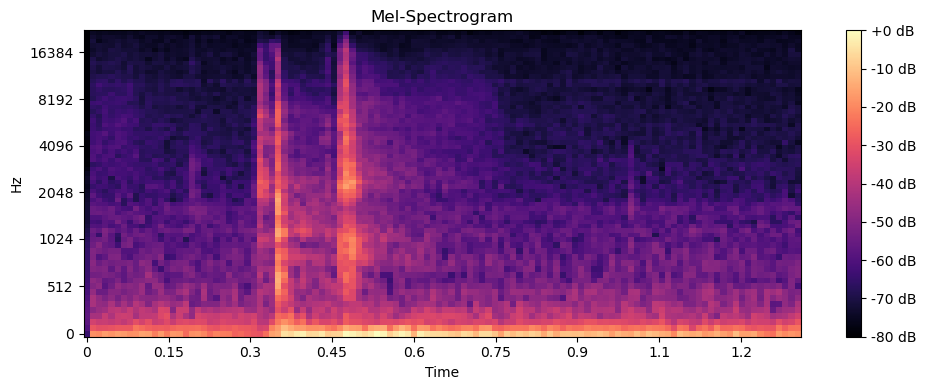

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
filename = '../data/Basem/data/key_data/key_press_space_1720384124_Basem.wav'
samples, sr = librosa.load(filename, sr=None)

# Compute the mel-spectrogram
mel_spec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=64, win_length=1024, hop_length=500)

# Convert to decibels for better visualization
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=500, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

TODO:
- Add a name abbreviation for each audio file for the respective folders
- convert Switches to clicky or non clicky
    - Clicky: 
        - Bumpy
        - loud noise
        - Blue, green
    - Tactile:
        Bumpy, moderate noise. You feel the bump before it actuates. Usually no sound (halo clears, mx clears)
        - Brown, clear
    - Linear:
        - Smooth
        - COnsistent, almost no noise
        - Red, Yellow, Black

Sound:
    - Switch itself
    - Heavy the switch itself is
    - Mechanism of switch
    - Case material (plastic, aluminum, brass, combo)
    - Design(hwo much empty space)
    - Floating keycap design or not
    - Keycaps(ABS, PBT)
    - thickness of keycap.
    - shape of keycap
    - Lubed or not
    - Stabilizers present? Are they modded or not?


* **mel-spectrograms** as a method of feature extraction for a DL mode

* Augmentation:
    * Signals were time-shifted randomly by up to 40% in either direction.
        - Helps increase amount of data
    * Mel-spectrograms generated using:
        * 64 mel brands
        * Window length of 1024 samples
        * hop length of 500 (255 for macbook keystrokes, given their shorter length)
        - results in 64x64 images
    * After Mel-spectrograms, complete masking:
        * take random 10% of both time and frequency axis and setting all values within those ranges to the mean of the spectrogram.
            - 'blocking out' a portion of the image.
            - Called SpecAugment and was foudn to encourage the model to generalise and avoid overfitting.
    